In [14]:
# Data convert for the original simulation test. 
# # convert_trace.py
def convert_trace_file(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line_num, line in enumerate(infile, 1):
            line = line.strip()
            if not line:  # Skip empty lines
                continue
                
            parts = line.split()
            if len(parts) < 4:
                print(f"Warning: Line {line_num} has insufficient columns: {line}")
                continue
            
            # Extract required fields
            timestamp = parts[0]          # Column 0: timestamp
            operation_raw = parts[1]      # Column 1: WS/RS
            file_id = parts[2]           # Column 2: file_id  
            file_size = parts[3]         # Column 3: file_size
            
            # Convert operation type: WS -> W, RS -> R
            if operation_raw == 'WS':
                operation_type = 'write'
            elif operation_raw == 'RS':
                operation_type = 'read'
            else:
                print(f"Warning: Unknown operation type '{operation_raw}' on line {line_num}")
                operation_type = operation_raw  # Keep original if unknown
            
            # Output in required format: timestamp,file_id,file_size,operation_type
            outfile.write(f"{timestamp},{file_id},{file_size},{operation_type}\n")
    
    print(f"Conversion completed! Output saved to {output_file}")

if __name__ == "__main__":
    convert_trace_file('data_trace/MSRC/wdev_3.revised', 'converted_trace.txt')

Conversion completed! Output saved to converted_trace.txt


In [ ]:
# Data convert for the RL data placement simulation test. 
def convert_trace_file(input_file, output_file):
    """
    Convert a storage trace to a CSV with:
    operation_type, LBA, block_size, inter_arrival, service_time, idle_time
    """
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line_num, line in enumerate(infile, 1):
            line = line.strip()
            if not line:
                continue

            parts = line.split()
            # Expecting at least 8 columns based on your description
            if len(parts) < 8:
                print(f"Warning: line {line_num} has insufficient columns: {line}")
                continue

            # parts mapping based on your dataset:
            # 0: timestamp
            # 1: WS/RS
            # 2: LBA
            # 3: block_size
            # 4: seq/rand   (we skip this)
            # 5: inter-arrival time
            # 6: service time
            # 7: idle time

            op_raw = parts[1]
            lba = parts[2]
            block_size = parts[3]
            inter_arrival = parts[5]
            service_time = parts[6]
            idle_time = parts[7]

            # normalize operation
            if op_raw == "WS":
                op = "write"
            elif op_raw == "RS":
                op = "read"
            else:
                print(f"Warning: unknown operation '{op_raw}' on line {line_num}")
                op = op_raw  # keep original

            # write in CSV format
            # operation, LBA, block_size, inter_arrival, service_time, idle_time
            outfile.write(f"{op},{lba},{block_size},{inter_arrival},{service_time},{idle_time}\n")

    print(f"Conversion completed. Output saved to {output_file}")


if __name__ == "__main__":
    convert_trace_file("wdev_3.revised", "converted_trace.csv")


Conversion completed. Output saved to converted_trace.csv


Trace Data Loaded Successfully!
Total I/O operations (WS + RS): 37415611

Operation type distribution:
operation_type
RS    21112615
WS    16302996
Name: count, dtype: int64

Missing values:
Total I/O operations (WS + RS): 37415611

Operation type distribution:
operation_type
RS    21112615
WS    16302996
Name: count, dtype: int64

Missing values:
timestamp         0
operation_type    0
LBA               0
data_size         0
access_pattern    0
inter_arrival     0
latency           0
idle_time         0
dtype: int64
timestamp         0
operation_type    0
LBA               0
data_size         0
access_pattern    0
inter_arrival     0
latency           0
idle_time         0
dtype: int64

After removing incomplete records: 37415611 records

After removing incomplete records: 37415611 records


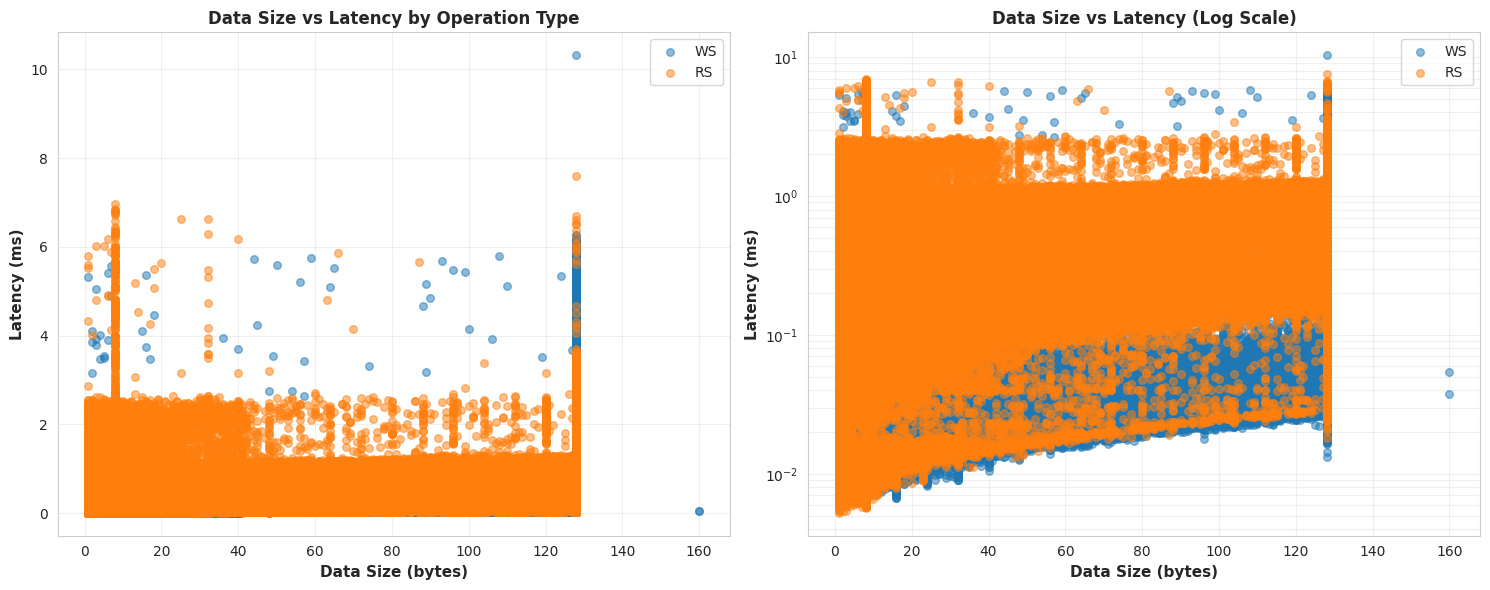

Figure 1 saved: 01_data_size_vs_latency.png


In [ ]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


# Load and parse the trace data
trace_file = 'data_trace/MSRC/src1_0.revised'

# Define column names based on the trace format
columns = ['timestamp', 'operation_type', 'LBA', 'data_size', 'access_pattern', 
           'inter_arrival', 'latency', 'idle_time']

# Read the trace file with space delimiter
df = pd.read_csv(trace_file, delimiter='\s+', names=columns, dtype={
    'timestamp': float,
    'operation_type': str,
    'LBA': int,
    'data_size': int,
    'access_pattern': str,
    'inter_arrival': float,
    'latency': float,
    'idle_time': float
})

print("Trace Data Loaded Successfully!")

# Filter for WS and RS operations only
io_operations = df[df['operation_type'].isin(['WS', 'RS'])].copy()

print(f"Total I/O operations (WS + RS): {len(io_operations)}")
print(f"\nOperation type distribution:")
print(io_operations['operation_type'].value_counts())

# Check for missing values
print(f"\nMissing values:")
print(io_operations.isnull().sum())

# Remove any rows with NaN values in critical columns
io_operations = io_operations.dropna(subset=['operation_type', 'data_size', 'latency'])

print(f"\nAfter removing incomplete records: {len(io_operations)} records")

# Convert latency from seconds to milliseconds for better readability
io_operations['latency_ms'] = io_operations['latency'] * 1000

# Create data size categories (in bytes)
def categorize_data_size(size):
    if size <= 8:
        return '8B'
    elif size <= 16:
        return '16B'
    elif size <= 128:
        return '128B'
    else:
        return 'Other'

io_operations['data_size_category'] = io_operations['data_size'].apply(categorize_data_size)

# Add index column for easy reference
io_operations['index'] = range(len(io_operations))


## Section 4: Visualize Data Size vs Latency
# Create scatter plots and line charts showing the relationship between data size and latency for both WS and RS operations.
# Figure 1: Scatter plot - Data Size vs Latency (colored by operation type)

# Store scatter plot collections for interactive use
scatter_collections = {}

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: All data points
ax1 = axes[0]
for op_type in ['WS', 'RS']:
    data = io_operations[io_operations['operation_type'] == op_type]
    scatter = ax1.scatter(data['data_size'], data['latency_ms'], alpha=0.5, s=30, label=op_type)
    scatter_collections[op_type] = (scatter, data)

ax1.set_xlabel('Data Size (bytes)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Latency (ms)', fontsize=11, fontweight='bold')
ax1.set_title('Data Size vs Latency by Operation Type', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Log scale for better visualization
ax2 = axes[1]
for op_type in ['WS', 'RS']:
    data = io_operations[io_operations['operation_type'] == op_type]
    scatter = ax2.scatter(data['data_size'], data['latency_ms'], alpha=0.5, s=30, label=op_type)

ax2.set_xlabel('Data Size (bytes)', fontsize=11, fontweight='bold')
ax2.set_ylabel('Latency (ms)', fontsize=11, fontweight='bold')
ax2.set_title('Data Size vs Latency (Log Scale)', fontsize=12, fontweight='bold')
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("Figure 1 saved: 01_data_size_vs_latency.png")

# Function to find and modify specific points
def find_outlier_points(threshold_percentile=95):
    """Find points with latency above a threshold (potential outliers)"""
    threshold = io_operations['latency_ms'].quantile(threshold_percentile / 100)
    outliers = io_operations[io_operations['latency_ms'] > threshold].copy()
    print(f"\n{'='*70}")
    print(f"Potential Outlier Points (above {threshold_percentile}th percentile: {threshold:.4f} ms)")
    print(f"{'='*70}")
    print(outliers[['index', 'operation_type', 'data_size', 'access_pattern', 'latency_ms']].to_string())
    return outliers

# Function to display point details
def show_point_details(index):
    """Show details for a specific point by index"""
    if index in io_operations['index'].values:
        point = io_operations[io_operations['index'] == index].iloc[0]
        print(f"\n{'='*70}")
        print(f"Point Details (Index: {index})")
        print(f"{'='*70}")
        print(f"Operation Type:    {point['operation_type']}")
        print(f"Data Size:         {point['data_size']} bytes")
        print(f"LBA:               {point['LBA']}")
        print(f"Access Pattern:    {point['access_pattern']}")
        print(f"Latency:           {point['latency']:.8f} seconds = {point['latency_ms']:.4f} ms")
        print(f"Inter-arrival:     {point['inter_arrival']:.8f} seconds")
        print(f"Idle Time:         {point['idle_time']:.8f} seconds")
        print(f"{'='*70}\n")
        return point
    else:
        print(f"Index {index} not found!")
        return None

# Function to modify a point's values
def modify_point(index, new_data_size=None, new_latency_ms=None):
    """Modify data_size or latency_ms for a specific point"""
    if index not in io_operations['index'].values:
        print(f"Index {index} not found!")
        return
    
    idx_loc = io_operations[io_operations['index'] == index].index[0]
    
    if new_data_size is not None:
        old_val = io_operations.loc[idx_loc, 'data_size']
        io_operations.loc[idx_loc, 'data_size'] = new_data_size
        print(f"✓ Point {index}: Data Size changed from {old_val} to {new_data_size}")
    
    if new_latency_ms is not None:
        old_val = io_operations.loc[idx_loc, 'latency_ms']
        io_operations.loc[idx_loc, 'latency_ms'] = new_latency_ms
        print(f"✓ Point {index}: Latency changed from {old_val:.4f} ms to {new_latency_ms:.4f} ms")

# Find outliers
outliers_df = find_outlier_points(95)

print("\n" + "="*70)
print("AVAILABLE FUNCTIONS:")
print("="*70)
print("1. show_point_details(index) - Display full details for a point")
print("2. modify_point(index, new_data_size=X, new_latency_ms=Y) - Modify a point")
print("3. find_outlier_points(percentile) - Find outlier points")
print("\nExample usage:")
print("  show_point_details(0)                    # Show details of point 0")
print("  modify_point(0, new_data_size=16)       # Change data size")
print("  modify_point(0, new_latency_ms=0.5)     # Change latency")
print("="*70)


Data Distribution Analysis:
------------------------------------------------------------
WS (Write) operations: 16302996
WS (Write) operations: 16302996
RS (Read) operations: 21112615

Access patterns:
access_pattern
rand    34118462
seq      3297149
Name: count, dtype: int64

Access patterns by operation type:
RS (Read) operations: 21112615

Access patterns:
access_pattern
rand    34118462
seq      3297149
Name: count, dtype: int64

Access patterns by operation type:
operation_type  access_pattern
RS              rand              18904879
                seq                2207736
WS              rand              15213583
                seq                1089413
dtype: int64
operation_type  access_pattern
RS              rand              18904879
                seq                2207736
WS              rand              15213583
                seq                1089413
dtype: int64

Creating pivot table for Access Pattern vs Operation Type...

Creating pivot table for Access

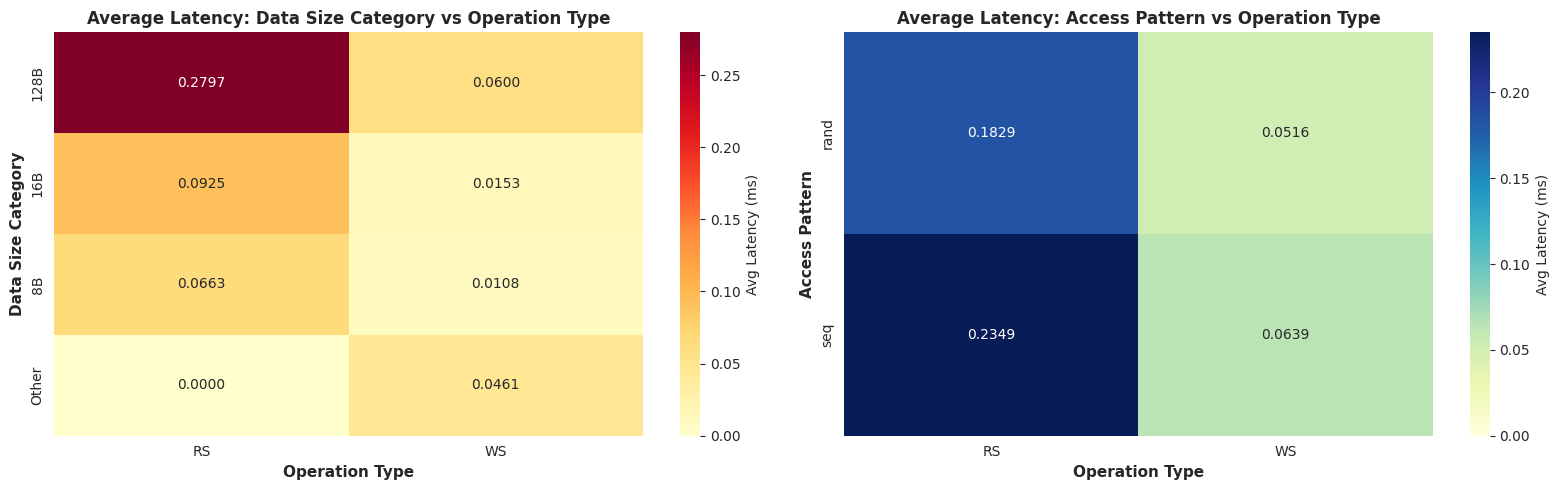


Heatmap visualization completed successfully!


In [4]:
# ## Section 6: Statistical Summary

# Generate correlation analysis between data size and latency, and provide summary tables showing average latency for different data size ranges and operation types.

print("\nData Distribution Analysis:")
print("-" * 60)
print(f"WS (Write) operations: {len(io_operations[io_operations['operation_type'] == 'WS'])}")
print(f"RS (Read) operations: {len(io_operations[io_operations['operation_type'] == 'RS'])}")
print(f"\nAccess patterns:")
print(io_operations['access_pattern'].value_counts())
print(f"\nAccess patterns by operation type:")
print(io_operations.groupby(['operation_type', 'access_pattern']).size())

# Create a heatmap showing average latency
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Heatmap 1: Operation Type vs Data Size Category
pivot_table1 = io_operations.pivot_table(values='latency_ms', 
                                         index='data_size_category', 
                                         columns='operation_type', 
                                         aggfunc='mean')

# Fill NaN values with 0 for better visualization
pivot_table1_filled = pivot_table1.fillna(0)

sns.heatmap(pivot_table1_filled, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[0], 
            cbar_kws={'label': 'Avg Latency (ms)'}, vmin=0)
axes[0].set_title('Average Latency: Data Size Category vs Operation Type', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Operation Type', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Data Size Category', fontsize=11, fontweight='bold')

# Heatmap 2: Operation Type vs Access Pattern
# Check which combinations exist
print(f"\nCreating pivot table for Access Pattern vs Operation Type...")
pivot_table2 = io_operations.pivot_table(values='latency_ms', 
                                         index='access_pattern', 
                                         columns='operation_type', 
                                         aggfunc='mean',
                                         fill_value=0)  # Fill missing values with 0

# If no data for a column, it won't appear, so we ensure both columns exist
if 'WS' not in pivot_table2.columns:
    pivot_table2['WS'] = 0
if 'RS' not in pivot_table2.columns:
    pivot_table2['RS'] = 0

# Reorder columns for consistency
pivot_table2 = pivot_table2[['RS', 'WS']]

print(f"Pivot table shape: {pivot_table2.shape}")
print(f"Pivot table:\n{pivot_table2}")

sns.heatmap(pivot_table2, annot=True, fmt='.4f', cmap='YlGnBu', ax=axes[1], 
            cbar_kws={'label': 'Avg Latency (ms)'}, vmin=0)
axes[1].set_title('Average Latency: Access Pattern vs Operation Type', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Operation Type', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Access Pattern', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nHeatmap visualization completed successfully!")

# Multi-Tier Storage System - Heatmap Analysis

This notebook creates heatmap visualizations for multi-tier storage performance metrics including:
- **Reads Count**: Number of read operations per tier
- **Writes Count**: Number of write operations per tier  
- **Served Time**: Total service time per tier (in hours)

Successfully read data from summary.txt

Storage Statistics DataFrame:
  Tier  Reads Count  Writes Count  Served Time (h)
0  RAM            0             0          0.00000
1  SSD            0             0          0.00000
2  HDD           10           670          0.01188

Data for Heatmap:
      Reads Count  Writes Count  Served Time (h)
Tier                                            
RAM             0             0          0.00000
SSD             0             0          0.00000
HDD            10           670          0.01188


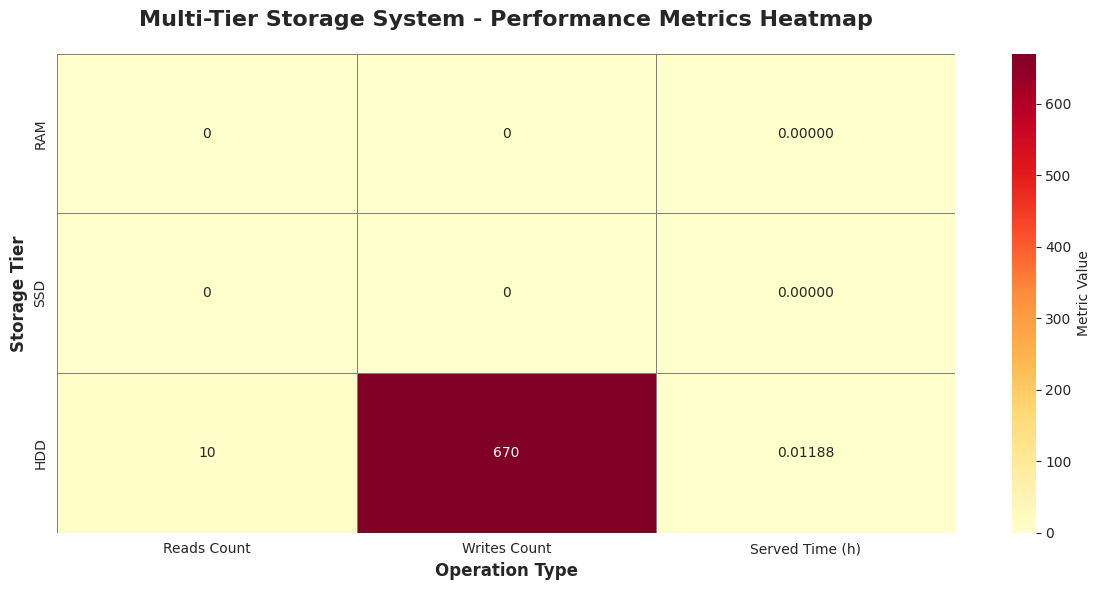

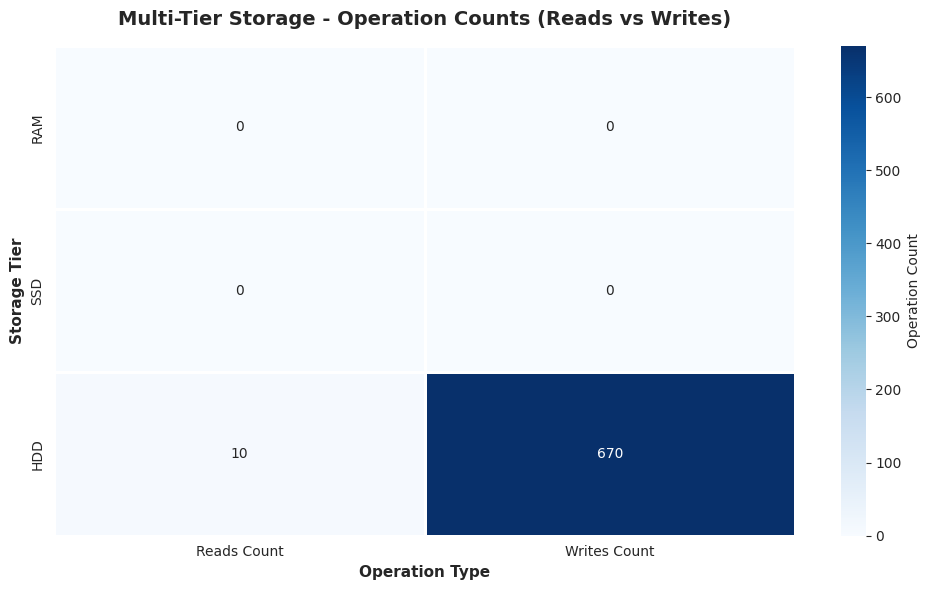

STORAGE SYSTEM SUMMARY STATISTICS

Total Operations: 680
  - Total Reads: 10
  - Total Writes: 670

Total Service Time: 0.011880 hours

Per-Tier Breakdown:
------------------------------------------------------------

RAM:
  Operations: 0 (0.0%)
    - Reads: 0, Writes: 0
  Service Time: 0.00000 h (0.0%)

SSD:
  Operations: 0 (0.0%)
    - Reads: 0, Writes: 0
  Service Time: 0.00000 h (0.0%)

HDD:
  Operations: 680 (100.0%)
    - Reads: 10, Writes: 670
  Service Time: 0.01188 h (100.0%)



In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 10)


# Function to read data from summary.txt
def read_summary_file(filename='summary.txt'):
    """Automatically parse summary.txt and extract storage metrics."""
    storage_data = {
        'Tier': [],
        'Reads Count': [],
        'Writes Count': [],
        'Served Time (h)': []
    }
    
    try:
        with open(filename, 'r') as f:
            content = f.read()
        
        # Parse Reads in each tier
        reads_ram = re.search(r'Numbers of Reads in RAM:\s*(\d+)', content)
        reads_ssd = re.search(r'Numbers of Reads in SSDs tier:\s*(\d+)', content)
        reads_hdd = re.search(r'Numbers of Reads in HDDs tier:\s*(\d+)', content)
        
        # Parse Writes in each tier
        writes_ram = re.search(r'Numbers of Writes in RAM:\s*(\d+)', content)
        writes_ssd = re.search(r'Numbers of Writes in SSDs tier:\s*(\d+)', content)
        writes_hdd = re.search(r'Numbers of Writes in HDDs tier:\s*(\d+)', content)
        
        # Parse Served Time in each tier
        time_ram = re.search(r'Total Served Time in RAM tier:\s*([\d.]+)\s*\[h\]', content)
        time_ssd = re.search(r'Total Served Time in SSDs tier:\s*([\d.]+)\s*\[h\]', content)
        time_hdd = re.search(r'Total Served Time in HDDs tier:\s*([\d.]+)\s*\[h\]', content)
        
        # Build storage_data dictionary
        tiers = ['RAM', 'SSD', 'HDD']
        reads = [int(reads_ram.group(1)) if reads_ram else 0,
                 int(reads_ssd.group(1)) if reads_ssd else 0,
                 int(reads_hdd.group(1)) if reads_hdd else 0]
        writes = [int(writes_ram.group(1)) if writes_ram else 0,
                  int(writes_ssd.group(1)) if writes_ssd else 0,
                  int(writes_hdd.group(1)) if writes_hdd else 0]
        times = [float(time_ram.group(1)) if time_ram else 0,
                 float(time_ssd.group(1)) if time_ssd else 0,
                 float(time_hdd.group(1)) if time_hdd else 0]
        
        storage_data['Tier'] = tiers
        storage_data['Reads Count'] = reads
        storage_data['Writes Count'] = writes
        storage_data['Served Time (h)'] = times
        
        print(f"Successfully read data from {filename}")
        
    except FileNotFoundError:
        print(f"Warning: {filename} not found. Using default data.")
        storage_data = {
            'Tier': ['RAM', 'SSD', 'HDD'],
            'Reads Count': [8, 2, 0],
            'Writes Count': [59, 23, 588],
            'Served Time (h)': [0.00019, 0.00021, 0.00844]
        }
    
    return storage_data


# Read data from summary.txt
storage_data = read_summary_file('summary.txt')

# Create DataFrame
df = pd.DataFrame(storage_data)
print("\nStorage Statistics DataFrame:")
print(df)
print()

# Set Tier as index for heatmap
df_heatmap = df.set_index('Tier')
print("Data for Heatmap:")
print(df_heatmap)

fig, ax = plt.subplots(figsize=(12, 6))

# Create custom annotations to avoid scientific notation
annot_array = np.empty_like(df_heatmap, dtype=object)
for i in range(len(df_heatmap)):
    for j in range(len(df_heatmap.columns)):
        val = df_heatmap.iloc[i, j]
        col_name = df_heatmap.columns[j]
        if 'Count' in col_name:
            annot_array[i, j] = f'{int(val):,}'  # Format with commas
        else:
            annot_array[i, j] = f'{val:.5f}'  # 5 decimal places

# Create heatmap with annotations
sns.heatmap(df_heatmap, 
            annot=annot_array,           # Show values in cells
            fmt='',                      # No auto formatting
            cmap='YlOrRd',               # Color map (Yellow to Orange to Red)
            cbar_kws={'label': 'Metric Value'},
            linewidths=0.5,
            linecolor='gray',
            ax=ax)

ax.set_title('Multi-Tier Storage System - Performance Metrics Heatmap', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Operation Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Storage Tier', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Create a matrix for operation counts only
operation_data = df[['Tier', 'Reads Count', 'Writes Count']].set_index('Tier')

fig, ax = plt.subplots(figsize=(10, 6))

# Custom annotations for operation counts with commas
annot_op = np.empty_like(operation_data, dtype=object)
for i in range(len(operation_data)):
    for j in range(len(operation_data.columns)):
        val = operation_data.iloc[i, j]
        annot_op[i, j] = f'{int(val):,}'

sns.heatmap(operation_data, 
            annot=annot_op,
            fmt='',
            cmap='Blues',
            cbar_kws={'label': 'Operation Count'},
            linewidths=1,
            linecolor='white',
            ax=ax)

ax.set_title('Multi-Tier Storage - Operation Counts (Reads vs Writes)', 
             fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Operation Type', fontsize=11, fontweight='bold')
ax.set_ylabel('Storage Tier', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# Calculate summary statistics
total_operations = df['Reads Count'].sum() + df['Writes Count'].sum()
total_served_time = df['Served Time (h)'].sum()

print("=" * 60)
print("STORAGE SYSTEM SUMMARY STATISTICS")
print("=" * 60)
print(f"\nTotal Operations: {total_operations:,}")
print(f"  - Total Reads: {df['Reads Count'].sum():,}")
print(f"  - Total Writes: {df['Writes Count'].sum():,}")
print(f"\nTotal Service Time: {total_served_time:.6f} hours")

print("\nPer-Tier Breakdown:")
print("-" * 60)
for idx, row in df.iterrows():
    tier = row['Tier']
    reads = row['Reads Count']
    writes = row['Writes Count']
    served_time = row['Served Time (h)']
    total_ops = reads + writes
    pct_ops = (total_ops / total_operations * 100) if total_operations > 0 else 0
    pct_time = (served_time / total_served_time * 100) if total_served_time > 0 else 0
    
    print(f"\n{tier}:")
    print(f"  Operations: {total_ops:,} ({pct_ops:.1f}%)")
    print(f"    - Reads: {reads:,}, Writes: {writes:,}")
    print(f"  Service Time: {served_time:.5f} h ({pct_time:.1f}%)")

print("\n" + "=" * 60)